### Visualizing Model Outputs

In [1]:
import pandas as pd
import numpy as np
from numpy import inf
import os
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas.plotting import register_matplotlib_converters

np.seterr(divide = 'ignore') 
pd.options.mode.chained_assignment = None
register_matplotlib_converters()
%matplotlib inline


Loading countries df

In [2]:
all_data = pd.read_pickle('.\\..\\data\\covid_df.pkl')

Loading linear regression predictions

In [3]:
output = pd.read_pickle('.\\..\\data\\predictions_log_total.pkl')

Neural Network Predictions

In [4]:
mlp = pd.read_pickle('.\\..\\data\\mlp_predictions.pkl')

Predictions with linear regression for different policy scenarios

In [39]:
death_strict_lr = pd.read_pickle('.\\..\\predictions\\deaths_lr_max_strignency.pkl')
death_lax_lr = pd.read_pickle('.\\..\\predictions\\deaths_lr_min_strignency.pkl')

Predictions with random forest for  different policy scenarios

In [5]:
death_strict = pd.read_pickle('.\\..\\predictions\\deaths_rf_max_stringency.pkl')
death_lax =pd.read_pickle('.\\..\\predictions\\deaths_rf_min_stringency.pkl')

Function to plot the prediction vs reality for one country using a model

In [6]:
def predicted_vs_real(full_df, output_df, country, target, logged=False, net=False):
    '''
    Plots one model's prediction vs real trend
    '''
    style.use('seaborn')
    date = output_df.index.min()
    pre = full_df[(full_df['Country'] == country) & (full_df['Date'] <= date)][[target, 'Date']]
    real = country + ' real'
    predict = country + ' prediction'
    post = output_df[[real, predict]]  
    day = pre['Date'].max() + dt.timedelta(days=-1)
    row = pre[pre['Date'] == day][[target, 'Date']]
    val = row[target]
    if logged:
        row[real], row[predict] = (np.log(val), np.log(val))
    else:
        row[real], row[predict] = (val, val)
    row.set_index('Date', inplace=True)
    post = row.append(post[[real, predict]])
    if logged:
        post = np.exp(post)
        
    fig, ax = plt.subplots(figsize=(12, 8))
    title = 'Prediction: {} in {}'.format(target, country)
    if net:
        title = 'Neural Net ' + title
    else:
        title = 'Linear Regression ' + title
    plt.title(label=title, fontsize=15)
    ax.axvline(x=date, ls=':', c='gray', label = str(date))
    g = sns.lineplot(x=post.index, y=post[real], ax=ax, marker='X', color='darkorange')
    g = sns.lineplot(x=post.index, y=post[predict], ax=ax, marker='X', color='g')
    g = sns.lineplot(x=pre['Date'], y=pre[target], ax=ax, color='royalblue')
    plt.legend(('Prediction frontier\n {}'.format(date), 'Real', 'Predicted', 'Trend'), prop={'size': 12})
    plt.ylabel(target)
    plt.show()

Function to plot two graphs of using two different models for one country

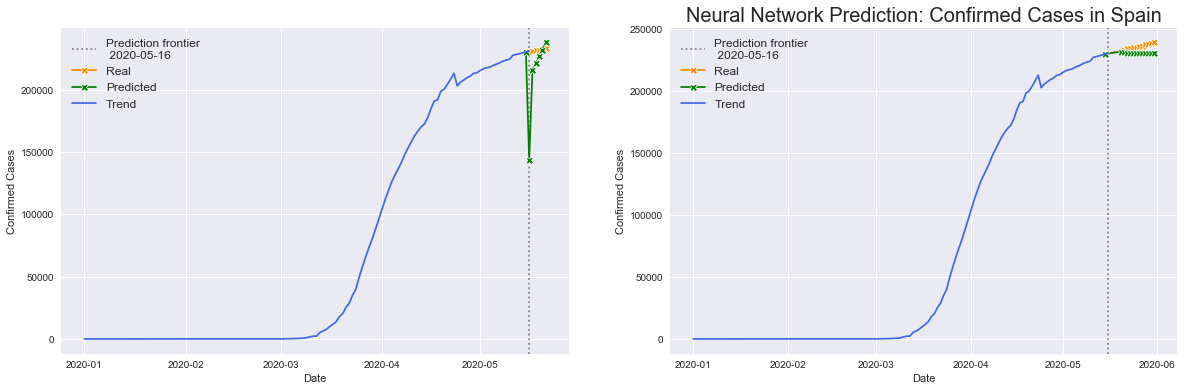

In [7]:
def side_by_side(full_df, country, target, models, *predictions, save_output=False, suptitle=None):
    '''
    Plots two different plots of models' predictions vs real trends side by side. 
    --first *predictions arg must be the one to be logged (LinReg)
    Inputs:
        full_df: (Pandas df) The full cleaned dataset
        country: (string) Country to examine
        target: (string) the outcome variable of the model
        models: (list) model names as strings
        *predictions: (tuple of Pandas df) collection of model prediction data
        save_output: (boolean) switch to save image output
    Output:
        File if save_output=True
        plots figure
    '''
    np.seterr(all='ignore')
    style.use('seaborn')
    date = predictions[0].index.min()
    pre = full_df[(full_df['Country'] == country) & (full_df['Date'] <= date)][[target, 'Date']]
    real, predict = (country + ' real', country + ' prediction')
    day = pre['Date'].max() + dt.timedelta(days=-1)
    fig, axes = plt.subplots(1, 2, figsize=(20,6))
    title = ' Prediction: {} in {}'.format(target, country)
    post_trends = []
    
    for pred, model in zip(predictions, models):

        post = pred[[real, predict]]
        row = pre[pre['Date'] == day][[target, 'Date']]
        row.set_index('Date', inplace=True)
        val = row[target]
        if model == 'Linear Regression':
            row[real], row[predict] = (np.log(val), np.log(val))
            post = np.exp(row.append(post[[real, predict]]))
        else:
            row[real], row[predict] = (val, val) 
            post = row.append(post[[real, predict]])
        post_trends.append(post)
    iterable = zip(models, predictions, axes, post_trends)
    for model, output, axis, trend in iterable:
        sub_title = model + title
        plt.title(sub_title, fontsize=20)
        axis.axvline(x=date, ls=':', c='gray', label = str(date))
        g = sns.lineplot(x=trend.index, y=trend[real], ax=axis, marker='X', color='darkorange')
        g = sns.lineplot(x=trend.index, y=trend[predict], ax=axis, marker='X', color='g')
        g = sns.lineplot(x=pre['Date'], y=pre[target], ax=axis, color='royalblue')
        axis.legend(('Prediction frontier\n {}'.format(date), 'Real', 'Predicted', 'Trend'), prop={'size': 12})
        plt.ylabel(target)    
    if save_output:
        file_name = '{} {} {} comparison.png'.format(country, *models)
        plt.savefig('.\\..\\visualizations\\' + file_name)
    if suptitle:
        plt.suptitle(suptitle, fontsize=21)
    plt.show()

side_by_side(all_data, 'Spain', 'Confirmed Cases', ['Linear Regression', 'Neural Network'], output, mlp, save_output=True)

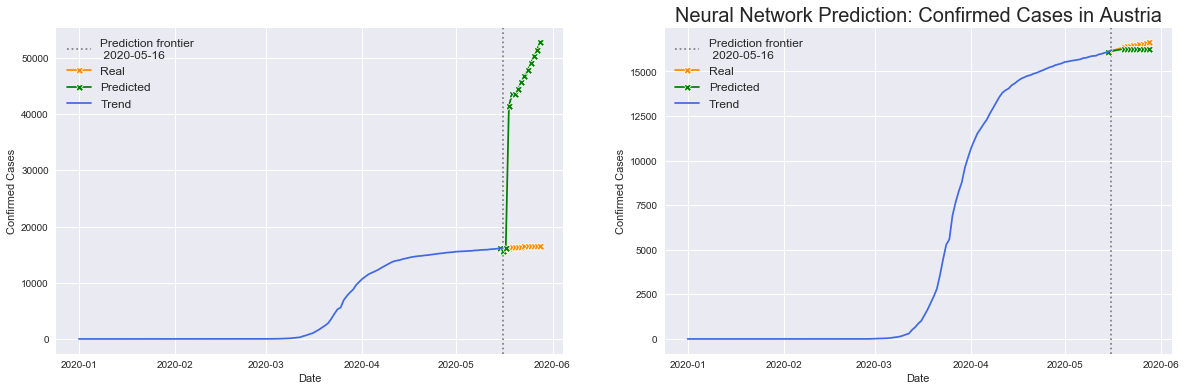

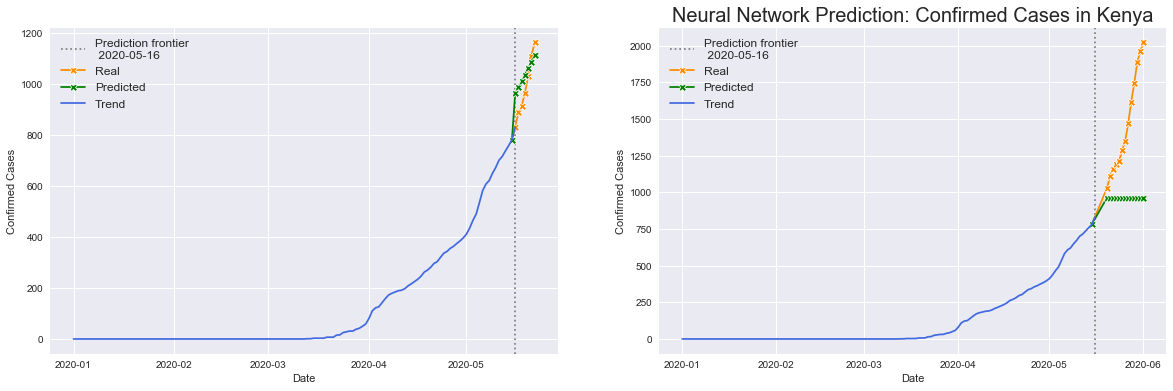

In [8]:
side_by_side(all_data, 'Austria', 'Confirmed Cases', ['Linear Regression', 'Neural Network'],output, mlp, save_output=True)
side_by_side(all_data, 'Kenya', 'Confirmed Cases', ['Linear Regression', 'Neural Network'],output, mlp, save_output=True)

In [9]:
#plots all the countries
'''
for country in all_data['Country'].unique():
    try:
        side_by_side(all_data, country, 'Deaths', ['Random Forest (Lax)', 'Random Forest (Strict)'], 
             death_lax, death_strict, save_output=False, 
             suptitle='Policy Comparison: Strict transport closure vs Lax transport closure')
    except:
        print('country missing:', country, '\n\n\n')
'''

"\nfor country in all_data['Country'].unique():\n    try:\n        side_by_side(all_data, country, 'Deaths', ['Random Forest (Lax)', 'Random Forest (Strict)'], \n             death_lax, death_strict, save_output=False, \n             suptitle='Policy Comparison: Strict transport closure vs Lax transport closure')\n    except:\n        print('country missing:', country, '\n\n\n')\n"

Loading different model evaulation metrics

In [12]:
performance = pd.read_pickle('.\\..\\predictions\\Evaluation_RMSE.pkl')

Function that plots model performance (i.e., Root Mean Squared Error) for two outcomes across all models

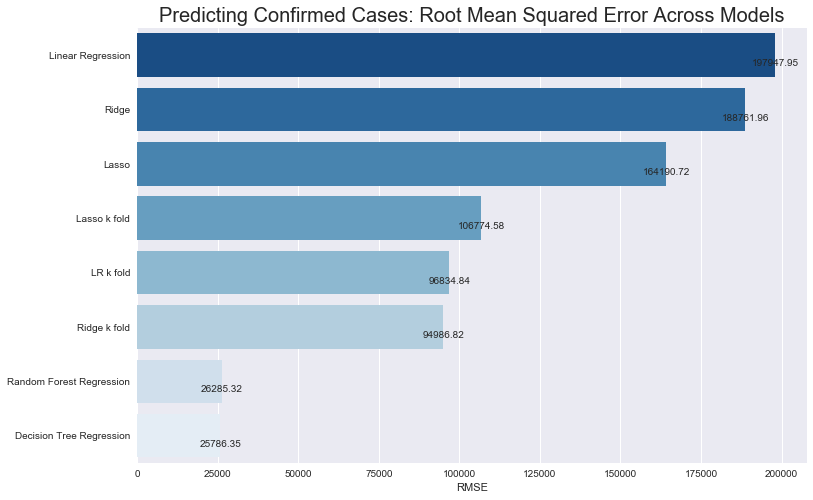

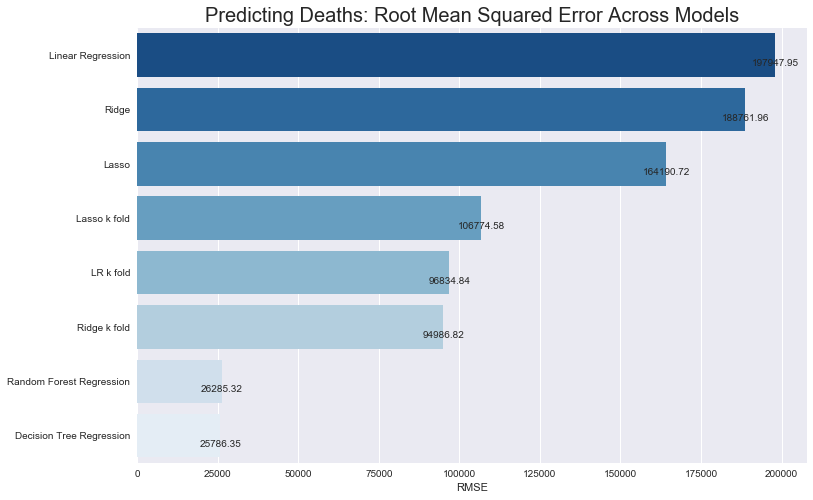

In [13]:
def plot_RMSE(df, target):
    df1 = df.copy()
    df1.reset_index(inplace=True)
    df1.sort_values(by='Confirmed Cases', inplace=True, ascending=False)
    df1.rename(columns={'index': 'model'}, inplace=True)
    df1['model'] = df1['model'].str.replace('_', ' ')
    fig, ax = plt.subplots(figsize=(12, 8))
    g = sns.barplot(df1['Confirmed Cases'], df1['model'],  palette='Blues_r')
    for p in g.patches:
        width = p.get_width()
        ax.text(width -1.5  ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}'.format(width),
            ha="center")
    plt.xlabel('RMSE')
    plt.ylabel('')
    plt.title('Predicting {}: Root Mean Squared Error Across Models'.format(target), fontsize=20)
    plt.show()
    
plot_RMSE(performance, 'Confirmed Cases')
plot_RMSE(performance, 'Deaths')


Function that plots two different hypothetical policy scenarios given a model and a country

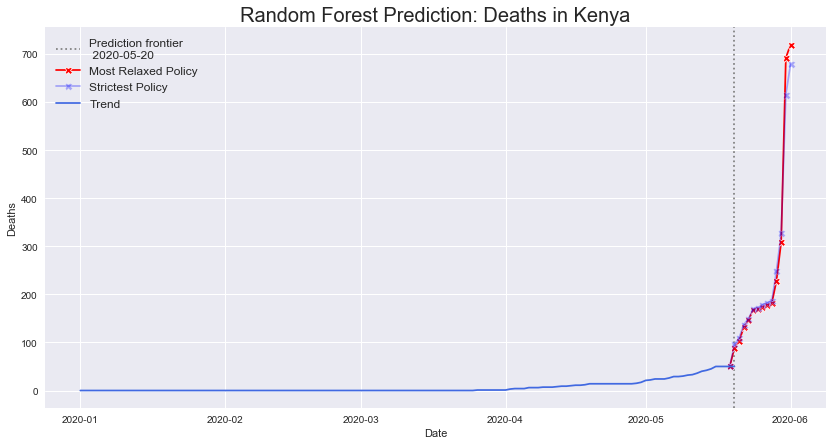

In [40]:

def policy_projections(full_df, country, target, models, *predictions, save_output=False, suptitle=None):
    '''
    '''
    np.seterr(all='ignore')
    style.use('seaborn')
    date = predictions[0].index.min()
    pre = full_df[(full_df['Country'] == country) & (full_df['Date'] <= date)][[target, 'Date']]
    real, predict = (country + ' real', country + ' prediction')
    day = pre['Date'].max() + dt.timedelta(days=-1)
    fig, ax1 = plt.subplots(figsize=(14,7))
    title = 'Random Forest Prediction: {} in {}'.format(target, country)
    post_trends = []
    
    for pred, model in zip(predictions, models):

        post = pred[[real, predict]]
        row = pre[pre['Date'] == day][[target, 'Date']]
        row.set_index('Date', inplace=True)
        val = row[target]
        if model == 'Linear Regression':
            row[real], row[predict] = (np.log(val + 1), np.log(val + 1))
            post = np.exp(row.append(post[[real, predict]]))
        else:
            row[real], row[predict] = (val, val) 
            post = row.append(post[[real, predict]])
        post_trends.append(post)
    ax1.axvline(x=date, ls=':', c='gray', label = str(date))
    plt.title(title.format(target, country), fontsize=20)
    g = sns.lineplot(x=post_trends[0].index, y=post_trends[0][predict], ax=ax1, marker='X', color='red')
    g = sns.lineplot(x=post_trends[1].index, y=post_trends[1][predict], ax=ax1, marker='X', color='blue', alpha =.3)
    g = sns.lineplot(x=pre['Date'], y=pre[target], ax=ax1, color='royalblue')
    ax1.legend(('Prediction frontier\n {}'.format(date), 'Most Relaxed Policy', 'Strictest Policy', 'Trend'), prop={'size': 12})
    plt.ylabel(target)    
    if save_output:
        file_name = '{} {} {} comparison.png'.format(country, *models)
        plt.savefig('.\\..\\visualizations\\' + file_name)
    plt.show()

policy_projections(all_data, 'Kenya', 'Deaths', ['Random Forest', 'Random Forest'],death_lax, death_strict, save_output=True)

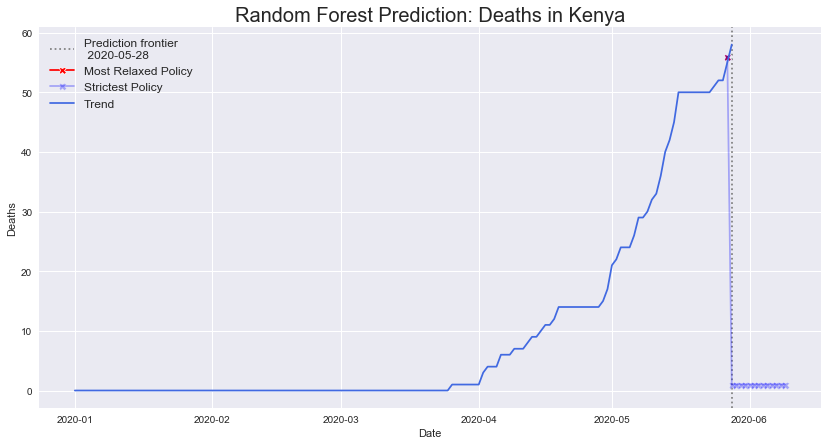

In [41]:
policy_projections(all_data, 'Kenya', 'Deaths', ['Linear Regression', 'Linear Regression'], death_lax_lr , death_strict_lr, save_output=True)

In [42]:
death_lax_lr.head(3)

,Afghanistan real,Afghanistan prediction,Albania real,Albania prediction,Algeria real,Algeria prediction,Angola real,Angola prediction,Argentina real,Argentina prediction,...,Venezuela real,Venezuela prediction,Vietnam real,Vietnam prediction,Yemen real,Yemen prediction,Zambia real,Zambia prediction,Zimbabwe real,Zimbabwe prediction
date,,,,,,,,,,,,,,,,,,,,,
2020-05-28,235.0,9.214814e+16,33.0,4.539899e+78,630.0,4.788835e-84,4.0,0.001268,508.0,2.821804e+79,...,11.0,1.579565e+38,0.0,3.853158e+159,57.0,7.821790e-86,7.0,1.178944e+78,4.0,1.591934e+17
2020-05-29,246.0,9.421397e+16,33.0,4.641677e+78,638.0,4.896157e-84,4.0,0.001296,520.0,2.885043e+79,...,14.0,1.614977e+38,0.0,3.939510e+159,65.0,7.997083e-86,7.0,1.205365e+78,4.0,1.627611e+17
2020-05-30,249.0,9.632538e+16,33.0,4.745701e+78,646.0,5.005922e-84,4.0,0.001325,528.0,2.949722e+79,...,14.0,1.651170e+38,0.0,4.027829e+159,77.0,8.176367e-86,7.0,1.232388e+78,4.0,1.664099e+17


In [43]:
death_strict_lr.head(3)

,Afghanistan real,Afghanistan prediction,Albania real,Albania prediction,Algeria real,Algeria prediction,Angola real,Angola prediction,Argentina real,Argentina prediction,...,Venezuela real,Venezuela prediction,Vietnam real,Vietnam prediction,Yemen real,Yemen prediction,Zambia real,Zambia prediction,Zimbabwe real,Zimbabwe prediction
date,,,,,,,,,,,,,,,,,,,,,
2020-05-28,235.0,0.0,33.0,0.0,630.0,0.0,4.0,0.0,508.0,0.0,...,11.0,0.0,0.0,0.0,57.0,0.0,7.0,0.0,4.0,0.0
2020-05-29,246.0,0.0,33.0,0.0,638.0,0.0,4.0,0.0,520.0,0.0,...,14.0,0.0,0.0,0.0,65.0,0.0,7.0,0.0,4.0,0.0
2020-05-30,249.0,0.0,33.0,0.0,646.0,0.0,4.0,0.0,528.0,0.0,...,14.0,0.0,0.0,0.0,77.0,0.0,7.0,0.0,4.0,0.0


End.